In [1]:
#HDBSCAN CLUSTERING
# Step 1- Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import hdbscan
from tqdm import tqdm


In [2]:
#Step 2 - Load and Normalise Data
print("Loading word frequencies...")
word_freq = pd.read_json("word_frequencies.json", orient="index")
word_freq.columns = ["frequency"]

print("Normalizing data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(word_freq)


Loading word frequencies...
Normalizing data...


Generating k-distance plot...


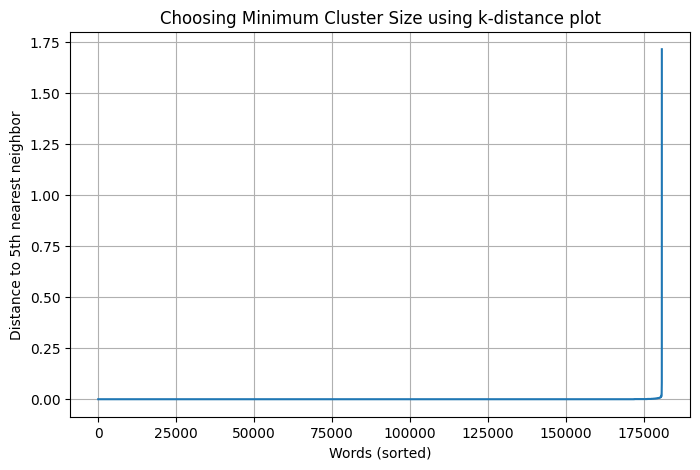

In [3]:
#Step 3 - Generate K-Distance plot fer estimating minimum clusters
print("Generating k-distance plot...")
k = 5  # Choose k for nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k, n_jobs=-1)
neighbors.fit(X_scaled)
distances, _ = neighbors.kneighbors(X_scaled)

distances = np.sort(distances[:, k - 1])  # Take the 5th nearest neighbor distance
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Words (sorted)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("Choosing Minimum Cluster Size using k-distance plot")
plt.grid()
plt.show()


In [4]:
# Step - 4 Define function for Evaluating HDBSCAN
def evaluate_hdbscan(min_cluster_size, min_samples, X_scaled):
    """Runs HDBSCAN and computes silhouette score."""
    try:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = clusterer.fit_predict(X_scaled)
        
        # Ensure more than one cluster exists
        if len(set(labels) - {-1}) > 1:
            score = silhouette_score(X_scaled, labels)
            return min_cluster_size, min_samples, score
        return min_cluster_size, min_samples, -1
    except Exception as e:
        print(f"Error with min_cluster_size={min_cluster_size}, min_samples={min_samples}: {e}")
        return min_cluster_size, min_samples, -1


In [5]:
# Step 5 - Parallell grid search for best HDBSCAN parameters
import concurrent.futures

print("Running parallel grid search for HDBSCAN parameters...")

best_min_cluster_size, best_min_samples, best_score = None, None, -1
min_cluster_sizes = range(5, 21, 2)  # Testing different min_cluster_size values
min_samples_values = range(3, 10, 2)  # Testing different min_samples values

param_grid = [(mcs, ms) for mcs in min_cluster_sizes for ms in min_samples_values]

# Run parallel evaluation
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(evaluate_hdbscan, mcs, ms, X_scaled): (mcs, ms) for mcs, ms in param_grid}
    
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="HDBSCAN Parameter Search"):
        min_cluster_size, min_samples, score = future.result()
        if score > best_score:
            best_min_cluster_size, best_min_samples, best_score = min_cluster_size, min_samples, score

print(f"Best parameters: min_cluster_size={best_min_cluster_size}, min_samples={best_min_samples}, silhouette_score={best_score}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Running parallel grid search for HDBSCAN parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Parameter Search:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Parameter Search:   3%|▎         | 1/32 [11:46<6:05:08, 706.71s/it]/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Parameter Search:   6%|▋         | 2/32 [11:54<2:27:45, 295.51s/it]/usr/l

Best parameters: min_cluster_size=5, min_samples=3, silhouette_score=0.9683086475678374


In [6]:
#Step 6 - Appy HDBSCAN with optimal parameters
print("Applying HDBSCAN with optimal parameters...")
hdb = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
clusters = hdb.fit_predict(X_scaled)

# Add clusters to DataFrame
word_freq["cluster"] = clusters
word_freq.to_csv("hdbscan_clusters.csv", index=True)


Applying HDBSCAN with optimal parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/tmp/ipykernel_32431/1436813509.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=word_freq["cluster"], palette="viridis")


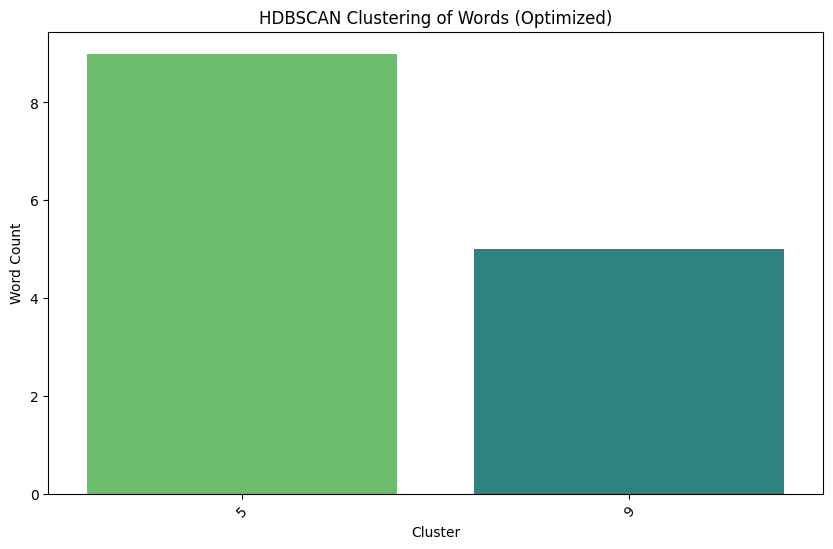

In [8]:
#Step 7 Visualise clusters

plt.figure(figsize=(10, 6))

# Convert clusters to string to avoid numeric interpretation issues
word_freq["cluster"] = word_freq["cluster"].astype(str)

sns.countplot(x=word_freq["cluster"], palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Word Count")
plt.title("HDBSCAN Clustering of Words (Optimized)")
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.show()


/tmp/ipykernel_32431/3007701339.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=word_freq['cluster'], palette='viridis')


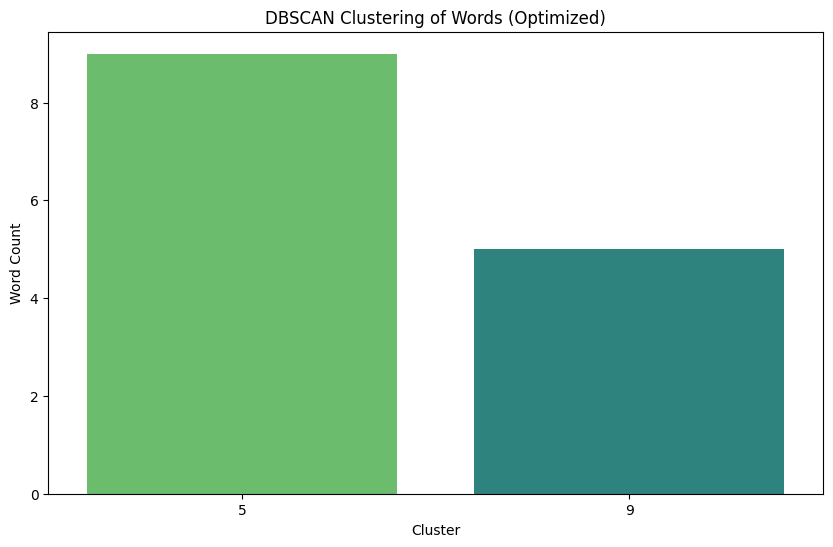

In [19]:
#Visualising clusters with scatter plot and PCA
# Visualize cluster distribution in a bar plot or histogram
plt.figure(figsize=(10, 6))
sns.countplot(x=word_freq['cluster'], palette='viridis')
plt.xlabel("Cluster")
plt.ylabel("Word Count")
plt.title("DBSCAN Clustering of Words (Optimized)")
plt.show()




In [20]:
#Step 8 Display sample cluster words
print("Displaying sample clustered words...")
print(word_freq.groupby("cluster").head(10))


Displaying sample clustered words...
                 frequency cluster
culinaria              105    1388
uso                   8710     121
adecuado               719    1118
especias               285    2026
imagen               15003      -1
...                    ...     ...
automáticamente        623    1339
llueva                 512    1278
anak                   607    1507
instalará              805     855
era                    642    1411

[17798 rows x 2 columns]


In [37]:
#LDA Semantic topic modelling
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

# Load Data & Assign Column Names
df = pd.read_csv("hdbscan_clusters.csv", header=None)
df.columns = ["word", "frequency", "cluster"]

# Step 1: Ensure Word Column Is Clean
df = df.dropna(subset=["word"])  # Drop rows where "word" is NaN
df["word"] = df["word"].astype(str)  # Convert to string

# Step 2: Group Words by Cluster
clustered_words = df.groupby("cluster")["word"].apply(list).reset_index()

# Step 3: Train Word2Vec (Ensuring Proper Word Lists)
word2vec_model = Word2Vec(sentences=clustered_words["word"].tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Step 4: Get Word Embeddings & Handle Missing Words
word_vectors = []
word_list = []
for cluster in clustered_words["word"]:
    for word in cluster:
        if word in word2vec_model.wv:  # Check if word exists in the model
            word_vectors.append(word2vec_model.wv[word])
            word_list.append(word)

word_vectors = np.array(word_vectors)  # Convert list to NumPy array

# Step 5: Cluster Words by Meaning (KMeans)
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
word_labels = kmeans.fit_predict(word_vectors)

# Step 6: Map Words to New Topics
word_cluster_mapping = {word: cluster for word, cluster in zip(word_list, word_labels)}
df["semantic_cluster"] = df["word"].map(word_cluster_mapping)

# Step 7: Vectorize Documents (TF-IDF)
df["text"] = df.groupby("semantic_cluster")["word"].transform(lambda x: " ".join(x))
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(df["text"].unique())

# Step 8: Apply LDA
num_topics = 20
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_tfidf)

# Step 9: Extract Top Words for Each Topic
words = vectorizer.get_feature_names_out()

def print_topics(model, feature_names, n_words=10):
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        print(f"Topic {idx + 1}: {', '.join(top_words)}")

print_topics(lda, words, n_words=10)




Topic 1: 기절할, surfaces, surging, aunt, 다크, forthcoming, 영업비용, 부채와, 다해서, 다이렉트
Topic 2: 미소는, 체계를, sampson, 남기고자, donanım, geminin, vẹn, 남겨질, informo, sancochado
Topic 3: ratito, 개선을, definder, 피하십시오, auron, 주유, pennsylvania, wickman, 주에서는, 반박이
Topic 4: simbol, 테마, btj, btc는, 문맹과, ustası, 분석한, nguy, bsw, kettlebell
Topic 5: blankets, setjen, 유세장, harmon, fante, 일관되게, 총리가, 물류에, 알려주었습니다, fixation
Topic 6: savor, 보유하든, jens, 가져갔습니다, 당선되면, bayou, 안좋은, arasındaki, protes, postcss
Topic 7: gampoeng, guru는, створити, trầm, створені, 할당을, trường, 류도와, gx의, trúc
Topic 8: moreau, femenina, 진흙을, gynefix, покупку, razionalità, running, badak, learner, pescadores
Topic 9: castración, quai, hikayede, 단순성은, qrdo, copilots, mendukung, stegmann, hiker, steerable
Topic 10: 설명한, 분배에, contrails, lechosa, smuggling, keilæ, ngontrak, 되겠네, 운전자보험은, ngăn
Topic 11: paysafe, muharam, 那雙腳, 집중형, creador, 관여하지, mug, createorder, 피해로, witty
Topic 12: católica, 만나도록, karel, 영감을, stro, stroberi, besitzer, 만남, karbon, stu

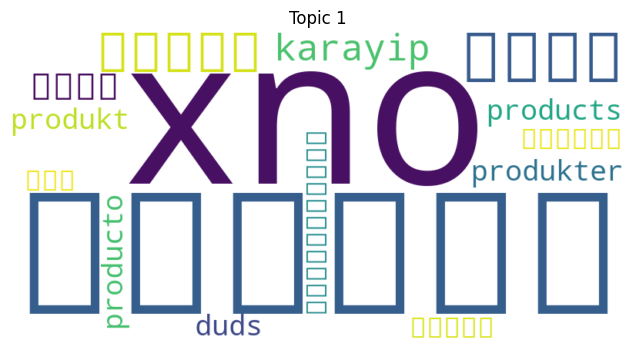

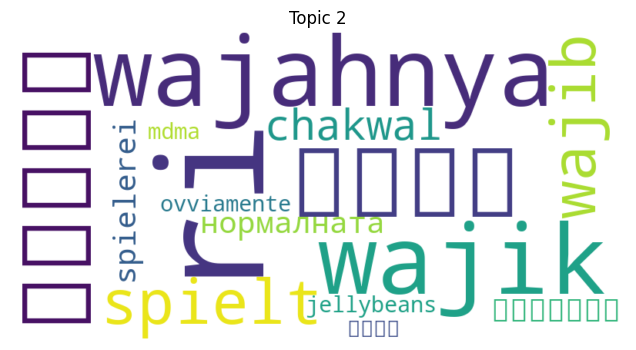

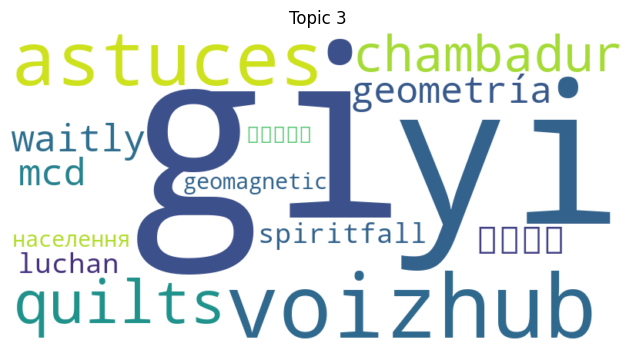

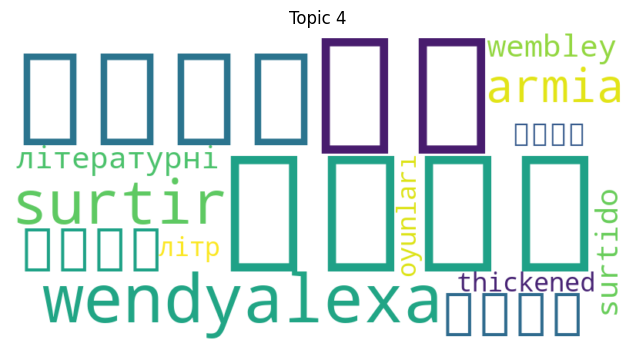

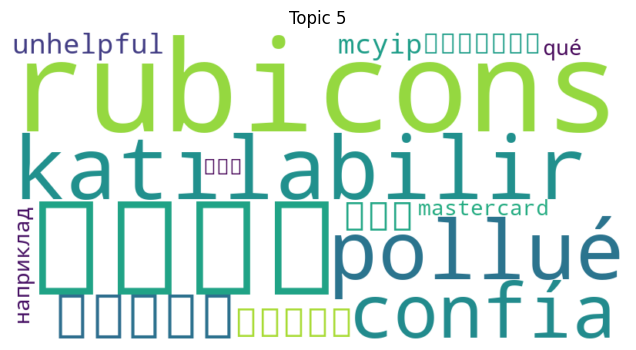

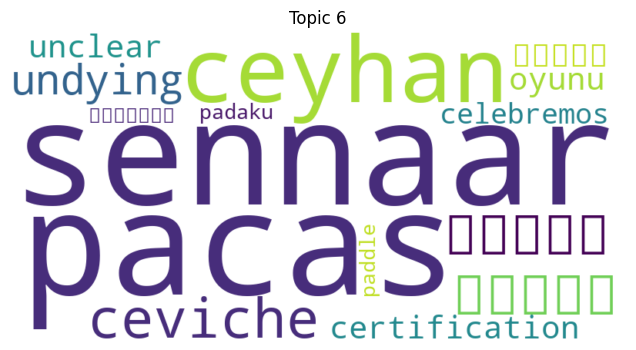

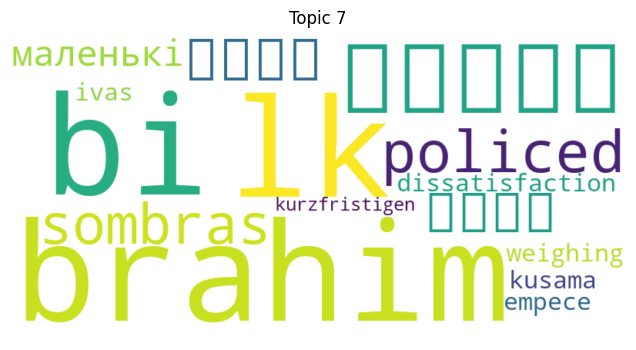

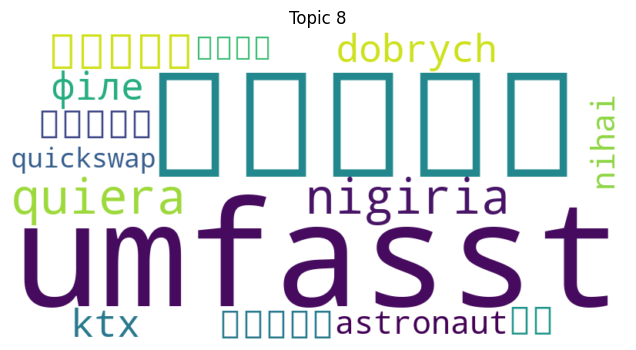

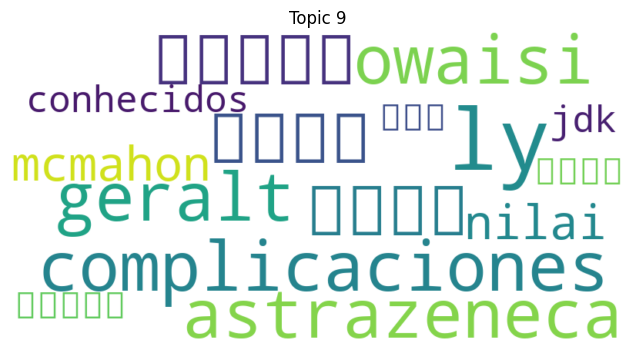

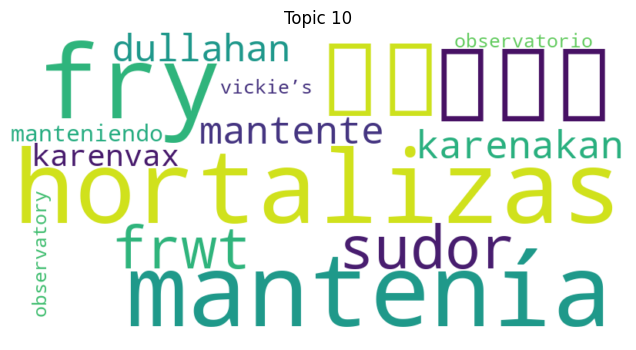

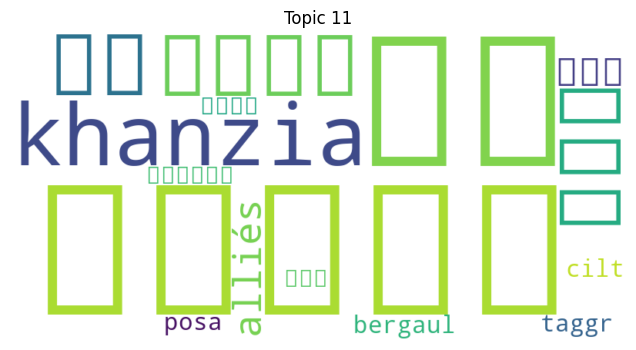

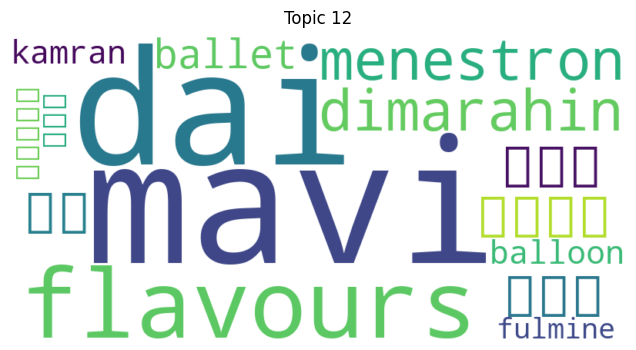

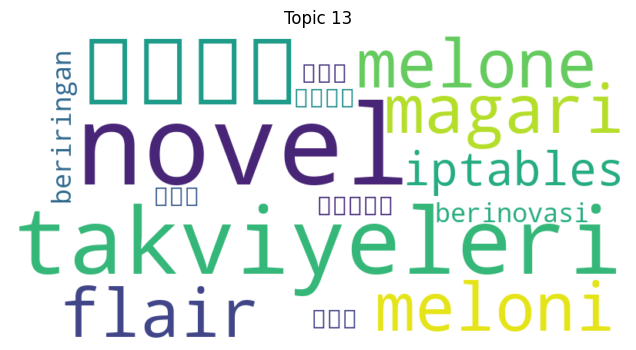

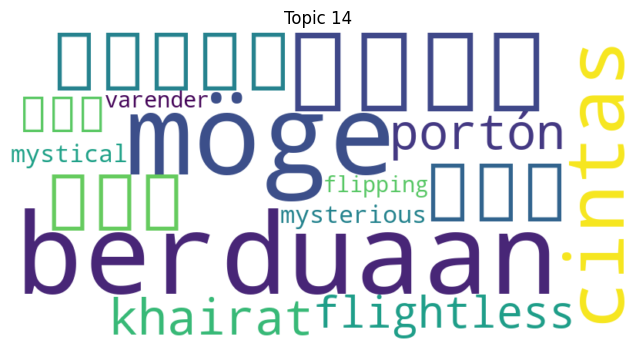

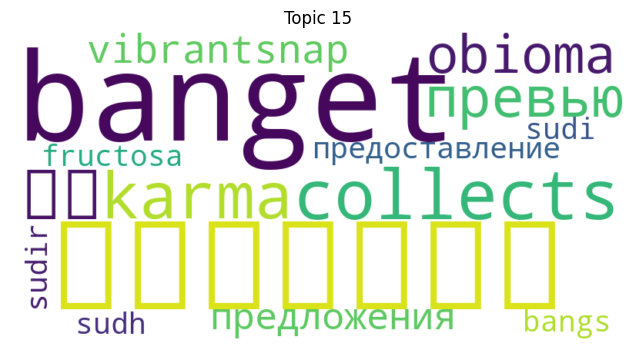

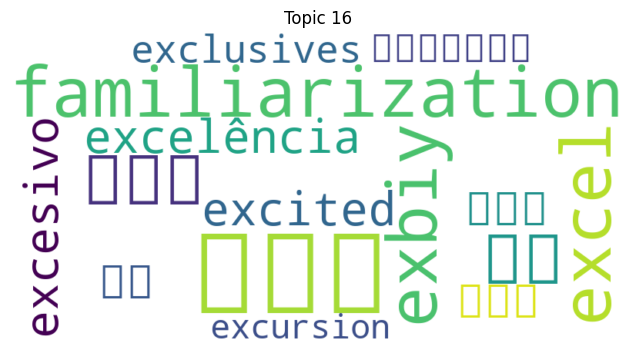

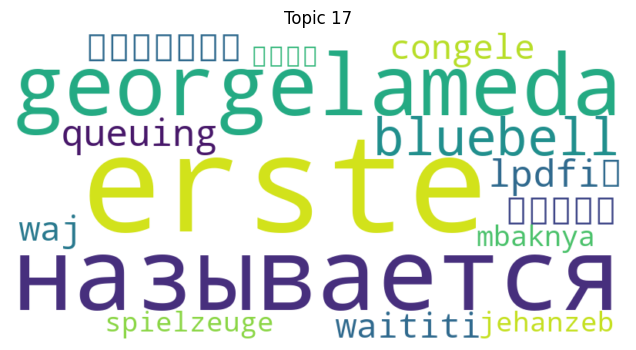

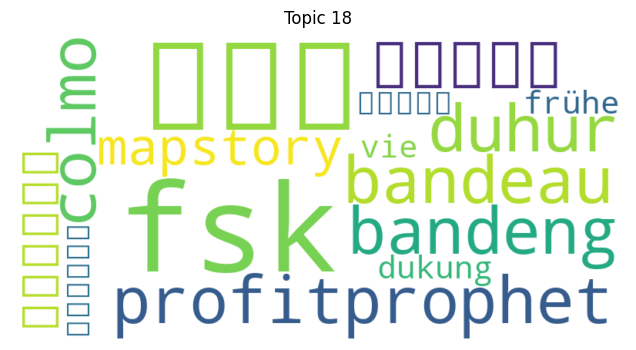

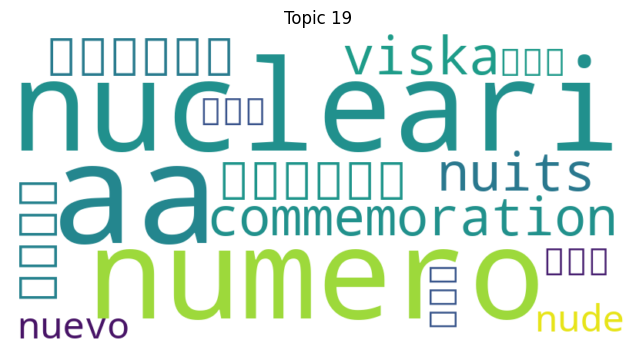

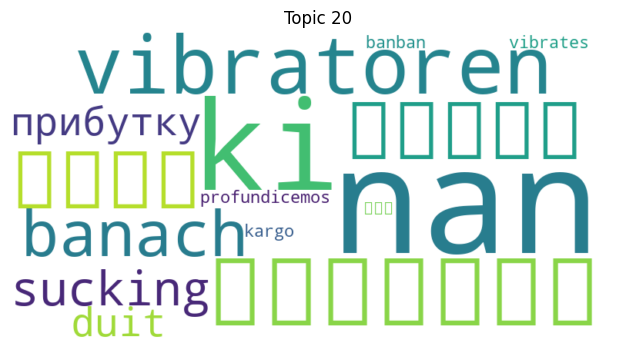

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load clustered words from CSV
file_path = "hdbscan_clusters.csv"
df = pd.read_csv(file_path, header=None)  # No header in the file
words = df.iloc[:, 0].astype(str)  # Extract words from index 0

# Convert words into a format suitable for LDA
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(words)

# Apply LDA
num_topics = 20
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_tfidf)

# Get vocabulary words
vocab_words = vectorizer.get_feature_names_out()

# Generate word clouds for each topic
def plot_word_cloud(topic_idx, topic):
    word_freq = {vocab_words[i]: topic[i] for i in topic.argsort()[:-15 - 1:-1]}  # Top 15 words
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()

# Generate and display word clouds
for topic_idx, topic in enumerate(lda.components_):
    plot_word_cloud(topic_idx, topic)


In [47]:
#Check number of documents
# If 'word_freq' contains the document data
num_documents = word_freq.shape[0]
print(f"Number of documents: {num_documents}")


Number of documents: 180655


In [26]:
#Group documents

# Group documents by their cluster labels
grouped_documents = word_freq.groupby("cluster")

# Display some of the grouped documents
for cluster_label, group in grouped_documents:
    print(f"\nCluster {cluster_label}:")
    print(group.head(5))  # Display the first 5 documents in each cluster



Cluster -1:
          frequency cluster
imagen        15003      -1
aprender       4045      -1
estuvo         6937      -1
sabía          2707      -1
elegir         2844      -1

Cluster 0:
           frequency cluster
excellent      18926       0
advantage      18870       0
tried          18890       0
trying         18455       0
paid           19030       0

Cluster 1:
         frequency cluster
welcome      18065       1
tag          18136       1
discord      18015       1
ask          18106       1
closed       18103       1

Cluster 10:
          frequency cluster
puedo         10880      10
target        10881      10
biasanya      10890      10
và            10902      10
drop          10913      10

Cluster 100:
        frequency cluster
oppo         8553     100
kontes       8552     100
copy         8544     100
cosa         8550     100
expect       8544     100

Cluster 1000:
             frequency cluster
berries            816    1000
hilsa              815    1000
